In [2069]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'figure.figsize': (10, 6),     
    'axes.titlesize': 16,           
    'axes.labelsize': 12,           
    'xtick.labelsize': 10,          
    'ytick.labelsize': 10,          
    'legend.fontsize': 11,          
    'axes.spines.top': False,       
    'axes.spines.right': False,     
}) #ставлю параметры для всех последующих графиков для единообразия

sns.set_palette("viridis")

In [2070]:
df = pd.read_csv("credit_risk_dataset.csv")
df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.00,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.00,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.00,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.00,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.00,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [2071]:
df.shape

(32581, 12)

In [2072]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

Все типы соответствуют тому, что ожидается в признаках. Посмотрим, есть ли дублирующиеся данные. 

In [2073]:
df.duplicated().sum()

np.int64(165)

In [2074]:
df.drop_duplicates(inplace=True)
df.shape

(32416, 12)

In [2075]:
def missing_value_table(df):
    
    '''Функция, возвращающая на выходе таблицу с анализом пропусков:

    Строки - пропущенные признаки
    Столбцы - количество пропущенных значений и процент пропусков от общего числа
    
    '''
    mis_val = df.isnull().sum()

    mis_val_percent = 100 * mis_val  / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table = mis_val_table.rename(columns={0: 'Missing values', 1: '% of total values'})

    mis_val_table = mis_val_table[mis_val_table.iloc[:, 1] != 0].sort_values('% of total values', ascending=False).round(1)

    print ("Датасет содержит " + str(df.shape[1]) + " столбцов.\n"      
            + str(mis_val_table.shape[0]) + " столбца содержат пропуски.")
        
    return mis_val_table

In [2076]:
missing_value_table(df)

Датасет содержит 12 столбцов.
2 столбца содержат пропуски.


,Missing values,% of total values
loan_int_rate,3095,9.50
person_emp_length,887,2.70


Данные пропущены в двух признаках. Задача - разобраться, по какой причине они могли быть пропущены и что делать в итоге с пропусками. Исследуем датасет подробнее.

In [2077]:
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,"32,416.00","32,416.00","31,529.00","32,416.00","29,321.00","32,416.00","32,416.00","32,416.00"
mean,27.75,"66,091.64",4.79,"9,593.85",11.02,0.22,0.17,5.81
std,6.35,"62,015.58",4.15,"6,322.73",3.24,0.41,0.11,4.06
min,20.00,"4,000.00",0.00,500.00,5.42,0.00,0.00,2.00
25%,23.00,"38,542.00",2.00,"5,000.00",7.90,0.00,0.09,3.00
50%,26.00,"55,000.00",4.00,"8,000.00",10.99,0.00,0.15,4.00
75%,30.00,"79,218.00",7.00,"12,250.00",13.47,0.00,0.23,8.00
max,144.00,"6,000,000.00",123.00,"35,000.00",23.22,1.00,0.83,30.00


Можно наблюдать, что в некоторых признаках есть очень странные выбросы, по типу максимального возраста в 144 года или стажа в 123 года. Данные необходимо почистить.

## Loan Status

Посмотрим, есть ли дисбаланс классов. 

In [2078]:
balance = df['loan_status'].value_counts()
balance

loan_status
0    25327
1     7089
Name: count, dtype: int64

In [2079]:
balance[0]/ (balance[0] + balance[1])

np.float64(0.7813116979269497)

Дисбаланс классов присутствует. Почти 78% данных с неодобрение кредита. Это важно учесть при построении модели. 

### Person income 

Для более быстрой визуализации я создам функции-шаблоны для отрисовки гистограмм и ящиков с усами. 

In [2080]:
def hist_plot(data, xlabel, bins=30, color='black'):

    '''
    Функция для отрисовки гистограмм

    data - данные
    bins - количество столбцов
    color - цвет границ
    xlabel - подпись оси X

    '''
    plt.hist(data, bins=bins, edgecolor=color)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {xlabel}')
    plt.show()

def boxplot(data, ylabel):

    '''
    Функция для отрисовки ящика с усами

    data - данные
    ylabel - подпись вертикальной оси
    
    '''
    plt.boxplot(data)
    plt.ylabel(ylabel)
    plt.title(f'Boxplot of {ylabel}')
    plt.show()


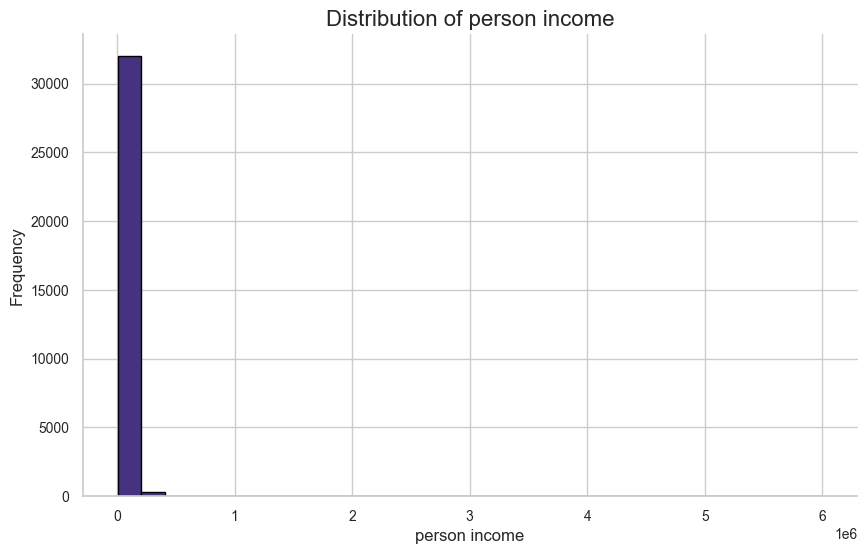

In [2081]:
hist_plot(df['person_income'],'person income')

Видим, что для основной массы объектов признак дохода принимает значение до 1 миллиона рублей, присутствуют какие-то сильные выбросы. Посмотрим, как ситуация выглядит на боксплоте.

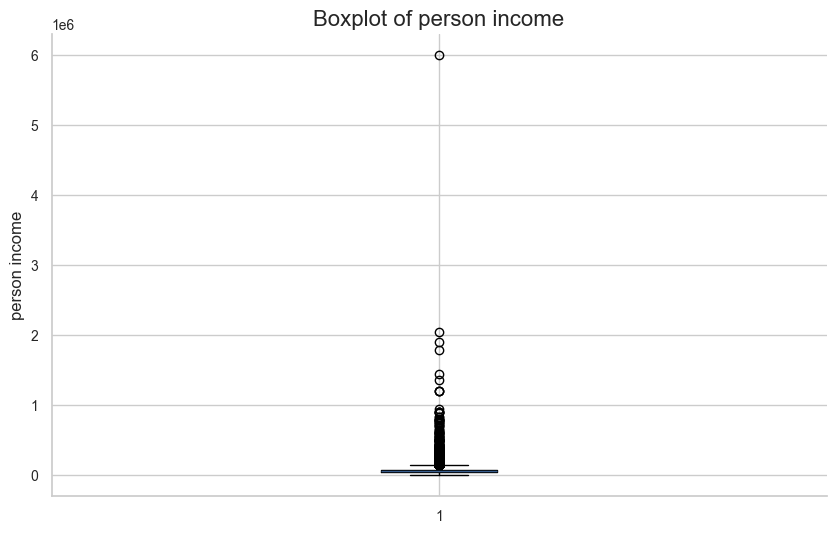

In [2082]:
boxplot(df['person_income'], 'person income')

Один очень крупный выброс в виде 6 млн рублей дохода. 

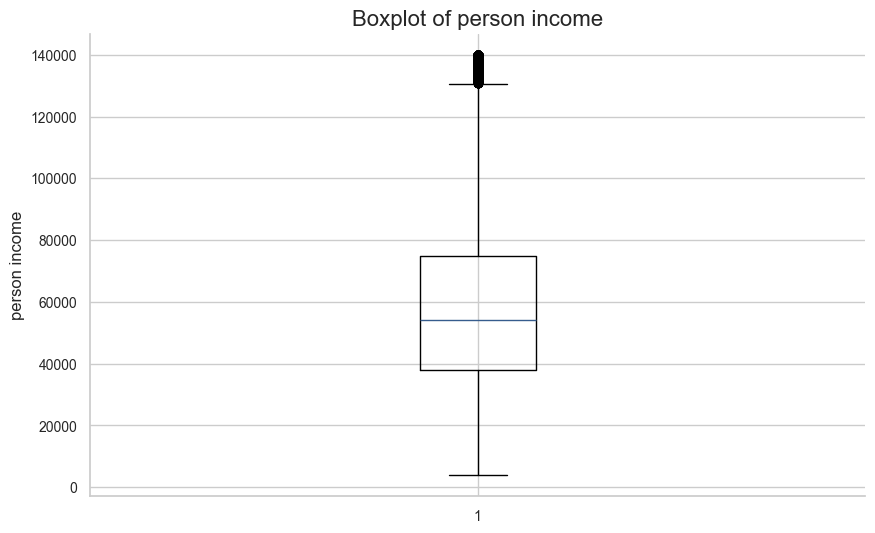

In [2083]:
Q1 = df['person_income'].quantile(0.25)
Q3 = df['person_income'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['person_income'] >= (Q1 - 1.5 * IQR)) & (df['person_income'] <= (Q3 + 1.5 * IQR))].copy()
boxplot(df['person_income'], 'person income')

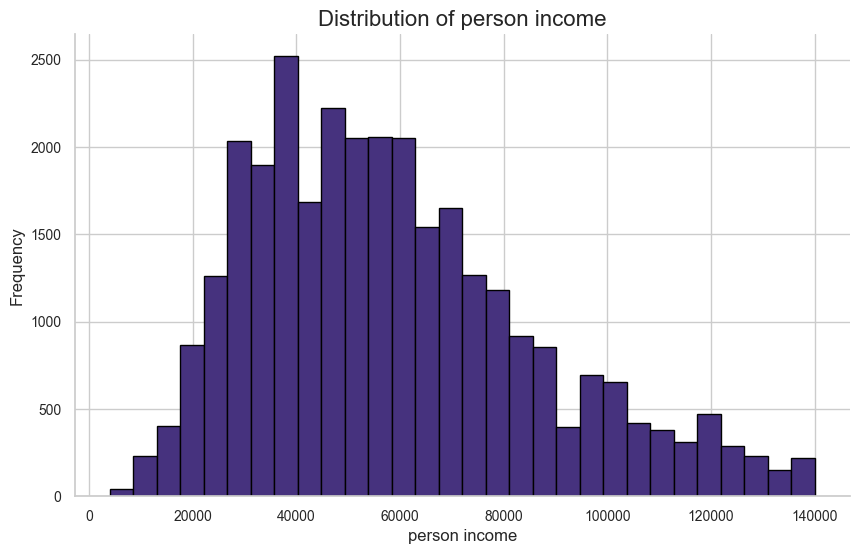

In [2084]:
hist_plot(df['person_income'], 'person income')

In [2085]:
df['person_income'].skew()

np.float64(0.7384018263648692)

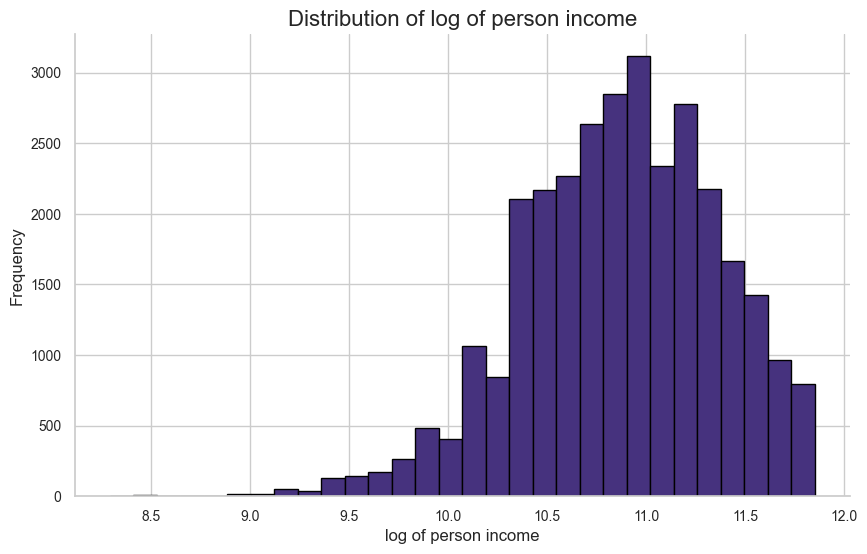

In [2086]:
df['log_person_income'] = np.log(df['person_income'])
hist_plot(df['log_person_income'], 'log of person income')

In [2087]:
df['log_person_income'].skew()

np.float64(-0.4447630491694093)

### Person age

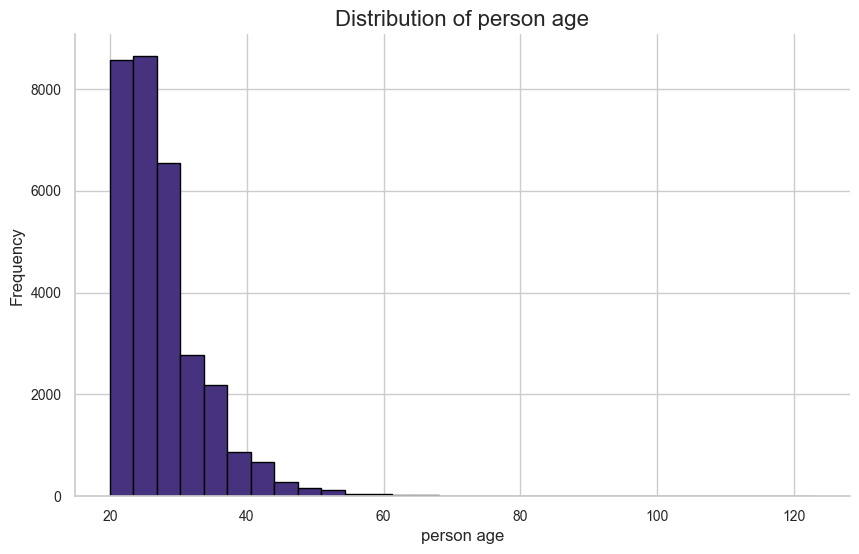

In [2088]:
hist_plot(df['person_age'],'person age')

Есть какое-то странное значение в 123 года. 

In [2089]:
df['person_age'].value_counts().sort_index(ascending=True).tail(10)

person_age
66     8
69     5
70     7
73     3
76     1
78     1
80     1
84     1
94     1
123    2
Name: count, dtype: int64

Я удалю последние два значения. 

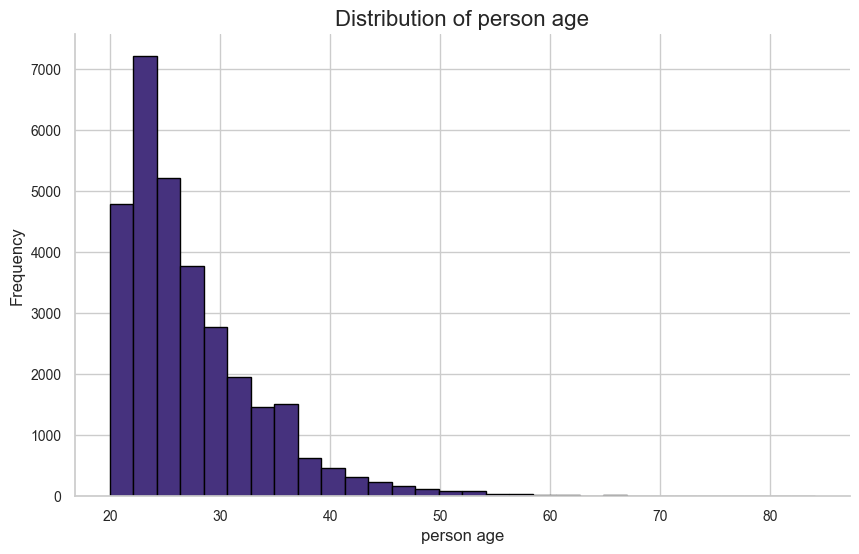

In [2090]:
df = df[df['person_age'] < 85].copy()
hist_plot(df['person_age'], 'person age')

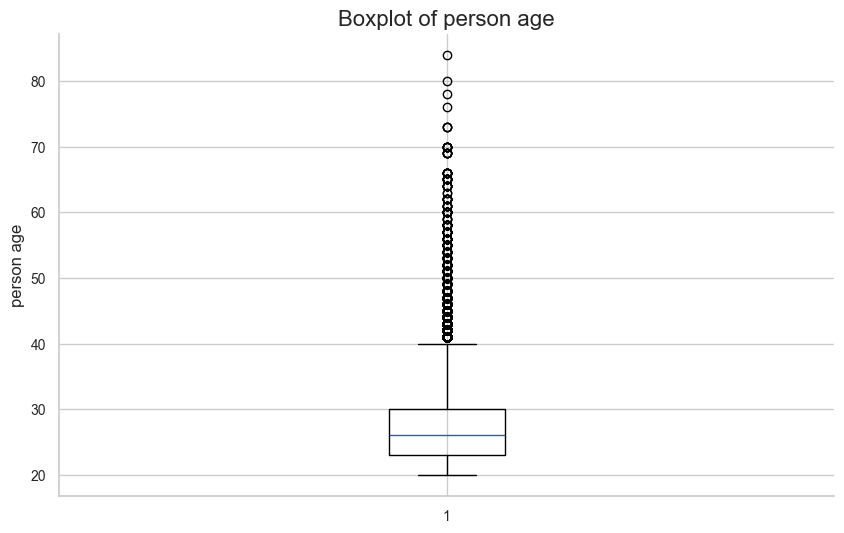

In [2091]:
boxplot(df['person_age'], 'person age')

Для задачи предсказания дефолта кажется, что будет разумным брать не возраст человека, а возрастную группу по нескольким причинам:

- В данных на конкретный возраст (например, 23 года) может прийтись случайный всплеск дефолтов, который не отражает реальную тенденцию. Группировка поможет усреднить этот шум.
- Риск дефолта не растет линейно с каждым годом жизни. Скорее, он меняется ступеньками в зависимости от жизненного этапа (студенчество, карьера, семья, пенсия).
- Модели проще выучить один весовой коэффициент для группы "20-25", чем пытаться найти закономерность для каждого года (21, 22, 23...), где данных может быть недостаточно.

In [2092]:
df['loan_status'].std()

np.float64(0.41726133982814784)

Попробуем разделить возраст на несколько смысловых групп и посмотрим на стандарнтное отклонение переменной loan_status в этом случае. 

In [2093]:
age_risk = df.groupby('person_age')['loan_status'].mean().reset_index()
bins = [19, 25, 30, 40, 50, 100]
labels = ['20-25', '26-30', '31-40', '41-50', '50+']
age_risk['age_group'] = pd.cut(age_risk['person_age'], bins=bins, labels=labels)
intra_group_std = age_risk.groupby('age_group', observed=False)['loan_status'].std()
print("Default variation (Standard Deviation):")
print(intra_group_std)

Default variation (Standard Deviation):
age_group
20-25   0.05
26-30   0.01
31-40   0.02
41-50   0.05
50+     0.18
Name: loan_status, dtype: float64


Варитивность маленькая, оставим такое разбиение. 

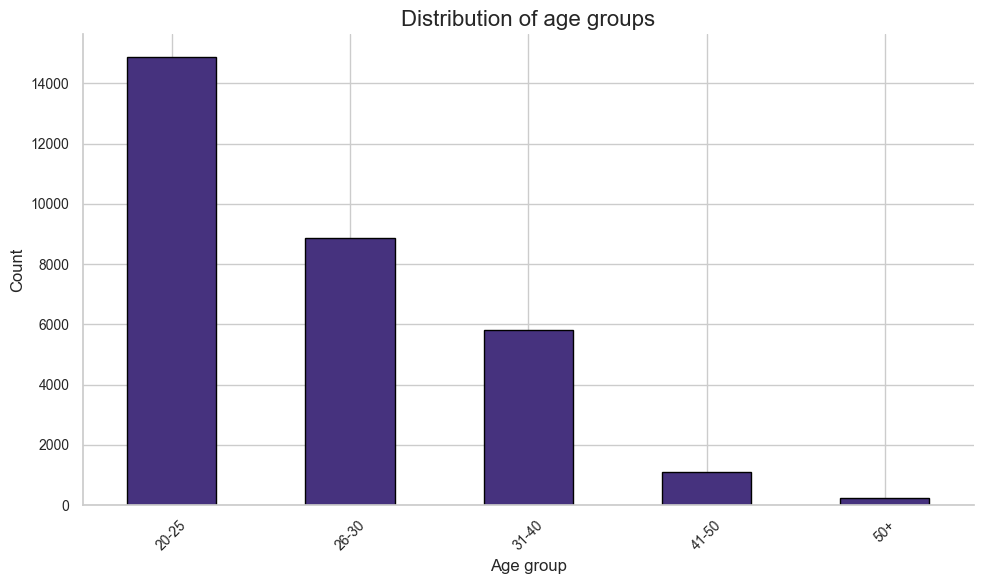

In [2094]:
df['age_group'] = pd.cut(df['person_age'], bins=bins, labels=labels)
age_counts = df['age_group'].value_counts().sort_index()
age_counts.plot(kind='bar', edgecolor='black')
plt.title('Distribution of age groups')
plt.xlabel('Age group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [2095]:
df.groupby('age_group', observed=False)['loan_status'].mean()

age_group
20-25   0.24
26-30   0.21
31-40   0.21
41-50   0.21
50+     0.27
Name: loan_status, dtype: float64

Видим, что среднее дефолта в возрастных группах от 26 до 50 одинаковый. В группе от 20 до 25 лет, а также в более возрастной группе от 50 более высокий риск неуплаты (эти категории менее стабильны в финансовом плане). 

### Employment length

In [2096]:
df['person_emp_length'].value_counts().sort_index(ascending=True)

person_emp_length
0.00      3945
1.00      2793
2.00      3682
3.00      3299
4.00      2758
5.00      2807
6.00      2575
7.00      2118
8.00      1579
9.00      1257
10.00      641
11.00      666
12.00      514
13.00      387
14.00      283
15.00      220
16.00      148
17.00      114
18.00       91
19.00       55
20.00       36
21.00       34
22.00       16
23.00       10
24.00        8
25.00        8
26.00        4
27.00        5
28.00        3
29.00        1
31.00        1
34.00        1
38.00        1
41.00        1
123.00       1
Name: count, dtype: int64

In [2097]:
df = df[(df['person_emp_length'] < 50) | (df['person_emp_length'].isnull())].copy()

Проверим, есть ли записи, где стаж больше, чем возраст. 

In [2098]:
df[df['person_emp_length'] >= df['person_age']]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,log_person_income,age_group


Таких записей не оказалось.

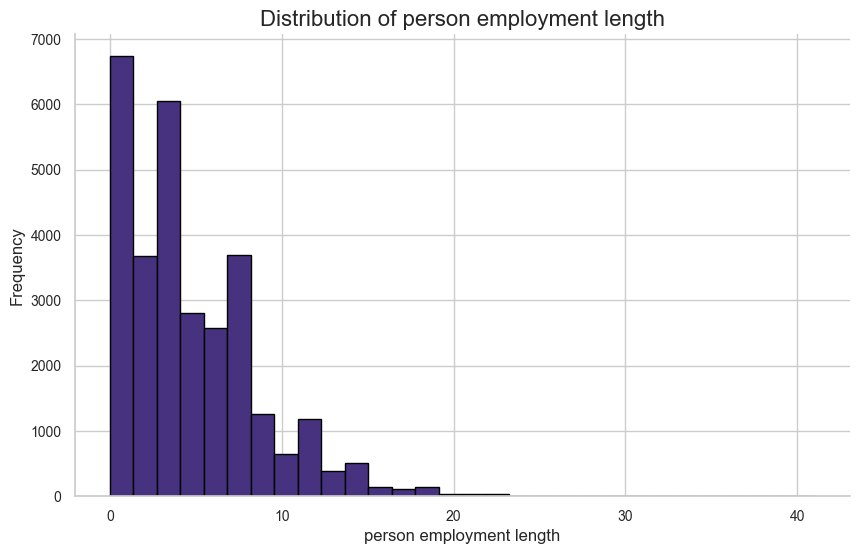

In [2099]:
hist_plot(df['person_emp_length'], 'person employment length')

Нужно внимательнее посмотреть, у каких именно объектов отсутствует стаж работы. Возможно, здесь присутствуют неслучайные пропуски.

In [2100]:
df['emp_is_missing'] = df['person_emp_length'].isnull().astype(int)
default_analysis = df.groupby('emp_is_missing')['loan_status'].mean()
default_analysis

emp_is_missing
0   0.22
1   0.32
Name: loan_status, dtype: float64

В среднем, тех, кто не указал стаж, возвращают кредит реже (их среднее ближе к 1, чем у тех, у кого стаж указан).

In [2101]:
income_analysis = df.groupby('emp_is_missing')['person_income'].median()
income_analysis

emp_is_missing
0   54,400.00
1   36,000.00
Name: person_income, dtype: float64

Доход у тех, у кого не указан стаж, ниже. 

In [2102]:
age_missing_pct = pd.crosstab(df['age_group'], df['emp_is_missing'], normalize='index') * 100
age_missing_pct

emp_is_missing,0,1
age_group,,
20-25,96.97,3.03
26-30,97.40,2.60
31-40,97.26,2.74
41-50,97.48,2.52
50+,98.44,1.56


Стаж пропущен примерно одинаково по возрастным категориям. 

Сохраним переменную, отражающую изначальный пропуск в данных, так как она, судя по статусу дефолта и по доходу, может быть важна. 

Посмотрим на взаимосвязь между возрастом и стажем.

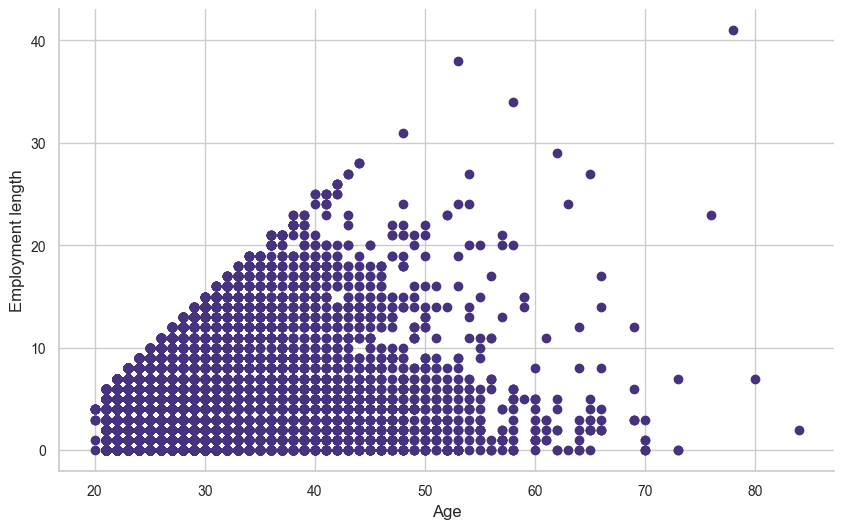

In [2103]:
plt.scatter(data=df, x='person_age', y='person_emp_length')
plt.xlabel('Age')
plt.ylabel('Employment length')
plt.show()

Заменим пропуски по стажу на медианный стаж в возрастной категории. 

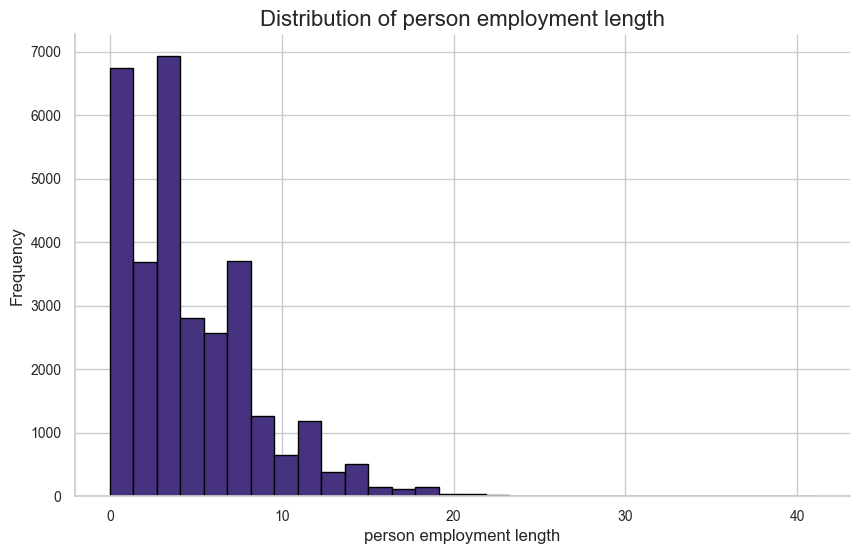

In [2104]:
df['person_emp_length'] = df.groupby('age_group', observed=False)['person_emp_length'].transform(lambda x: x.fillna(x.median()))
hist_plot(df['person_emp_length'], 'person employment length')

In [2105]:
# df = df[df['person_emp_length'] < 50].copy()
# bins = [0, 1, 3, 5, 10, 15, 20, 30, 50]
# labels = ['<1', '1-3', '3-5', '5-10', '10-15', '15-20', '20-30', '30+']
# df['emp_length_group'] = pd.cut(df['person_emp_length'], bins=bins, labels=labels, include_lowest=True)
# df

### Loan amount

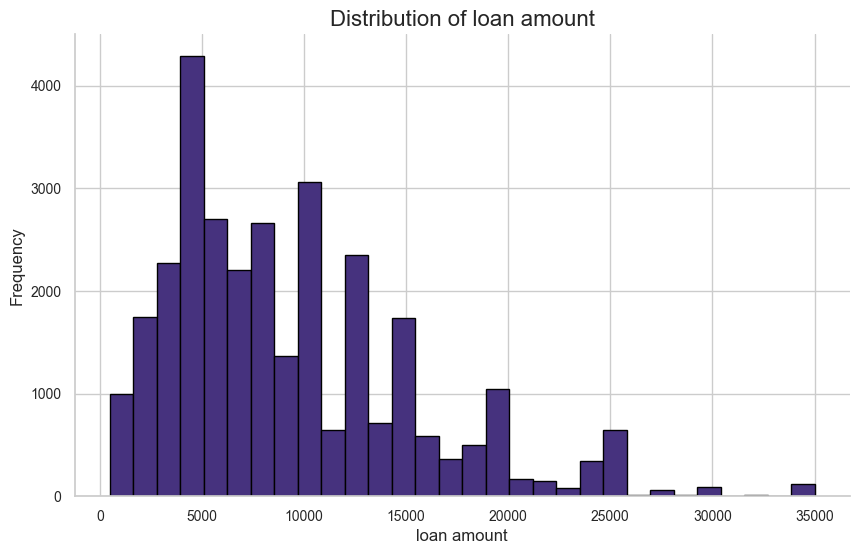

In [2106]:
hist_plot(df['loan_amnt'], 'loan amount')

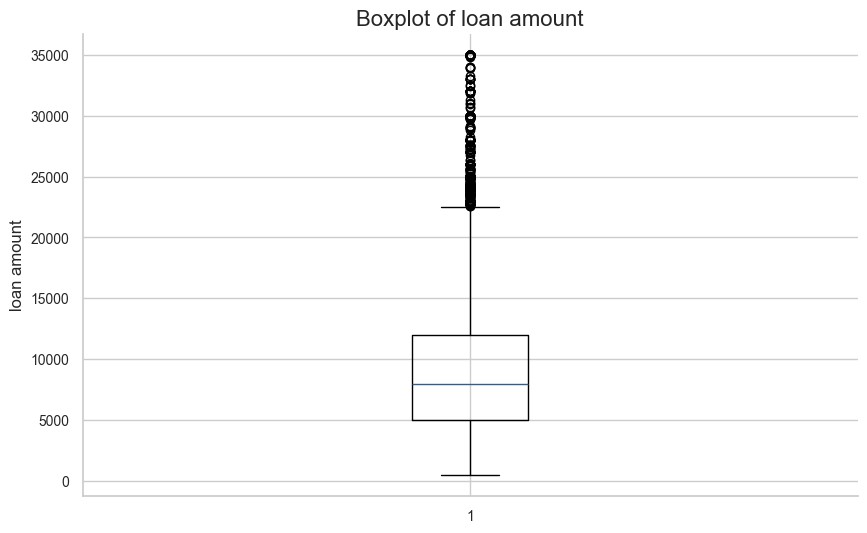

In [2107]:
boxplot(df['loan_amnt'], 'loan amount')

In [2108]:
df['loan_amnt'].skew()

np.float64(1.1782929877378603)

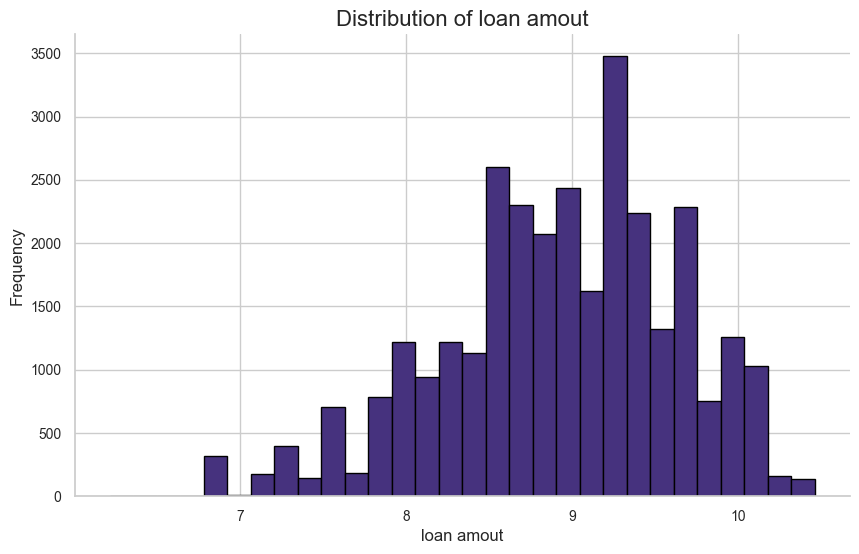

In [2109]:
df['loan_amnt'] = np.log(df['loan_amnt'])
hist_plot(df['loan_amnt'], 'loan amout' )

In [2110]:
df['loan_amnt'].skew()

np.float64(-0.46076228832399485)

### Loan interest rate

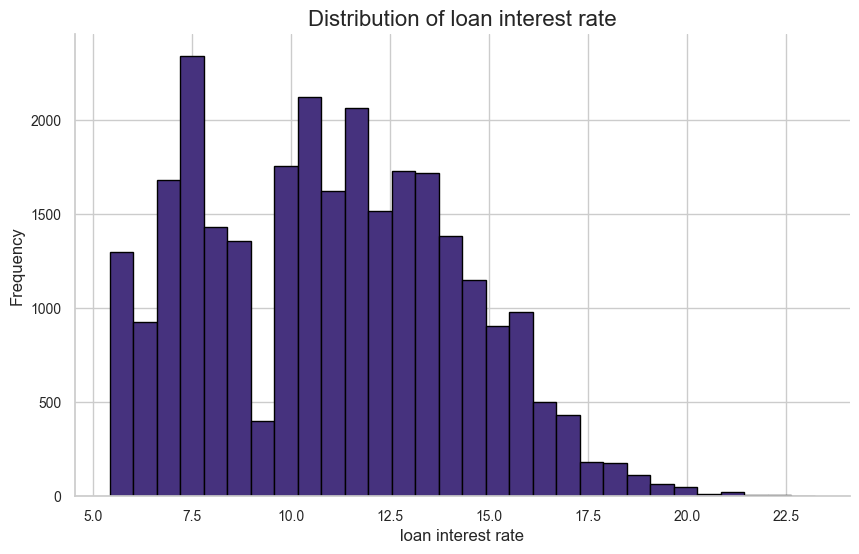

In [2111]:
hist_plot(df['loan_int_rate'], 'loan interest rate')

Исходя из того, что ставка формируется на основе ожидаемого риска, скорее всего будем наблюдать зависимость ставки от рейтинга кредита. 

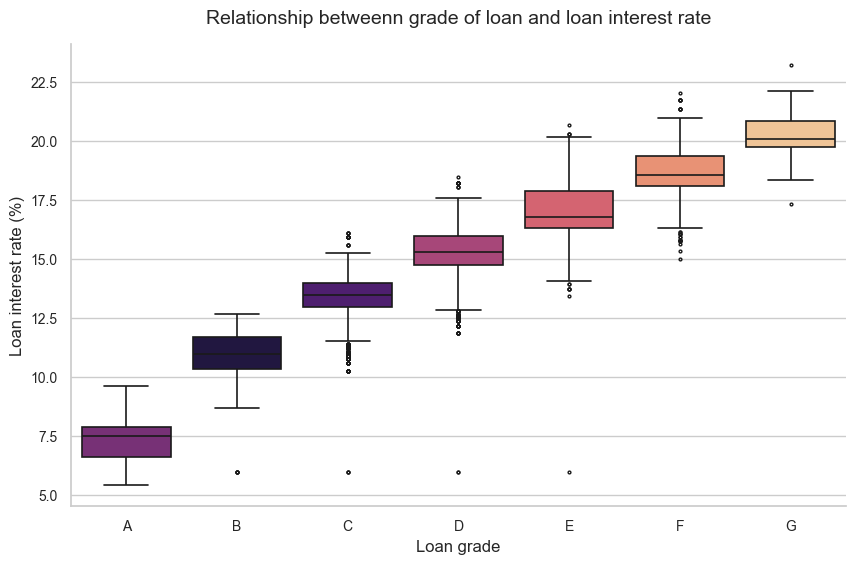

In [2112]:
grade_order = sorted(df['loan_grade'].unique())

plt.figure(figsize=(10, 6)) 

sns.boxplot(data=df, x='loan_grade', y='loan_int_rate', hue='loan_grade', order=grade_order,palette='magma', linewidth=1.2, fliersize=2)

plt.title('Relationship betweenn grade of loan and loan interest rate', fontsize=14, pad=15)
plt.xlabel('Loan grade', fontsize=12)
plt.ylabel('Loan interest rate (%)', fontsize=12)
plt.show()

Заполним пропуски в стаке медианой внутри грейда.

In [2113]:
df['loan_int_rate'] = df.groupby('loan_grade', observed=False)['loan_int_rate'].transform(lambda x: x.fillna(x.median()))

### Loan percent income

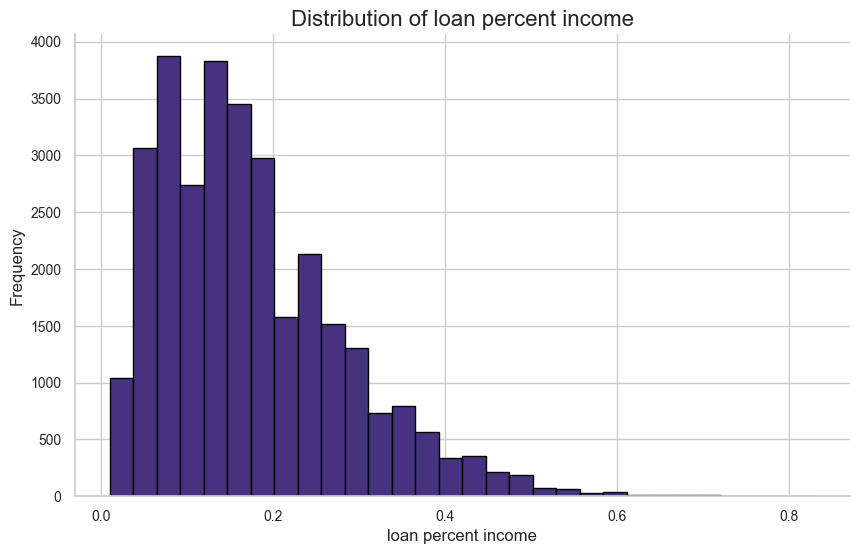

In [2114]:
hist_plot(df['loan_percent_income'], 'loan percent income' )

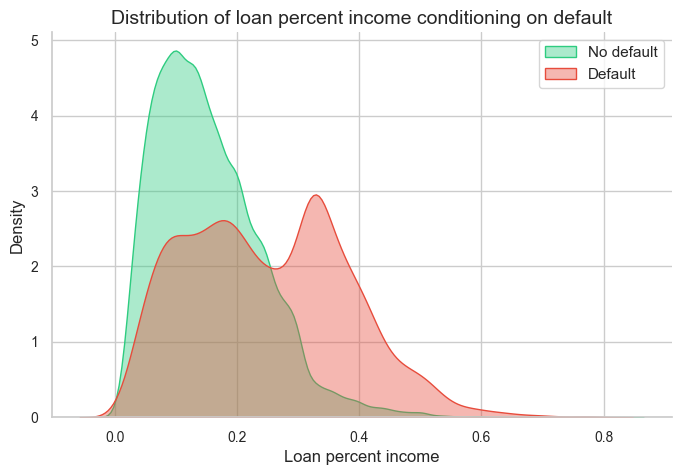

In [2115]:
plt.figure(figsize=(8, 5))

statuses = [0, 1]
labels = ['No default', 'Default']
colors = ["#2ecc80", '#e74c3c'] # Зеленый и Красный

for status, label, color in zip(statuses, labels, colors):
    subset = df[df['loan_status'] == status]
    
    sns.kdeplot(subset['loan_percent_income'].dropna(), label=label, fill=True, alpha=0.4,color=color)

plt.xlabel('Loan percent income', size=12)
plt.ylabel('Density', size=12)
plt.title('Distribution of loan percent income conditioning on default', size=14)
plt.legend()
plt.show()

Можно наблюдать, что те, у кого долговая нагрузка была ниже примерно 25% чаще возвращали кредит, а у кого была выше - не платили. 

### Personal credit history length

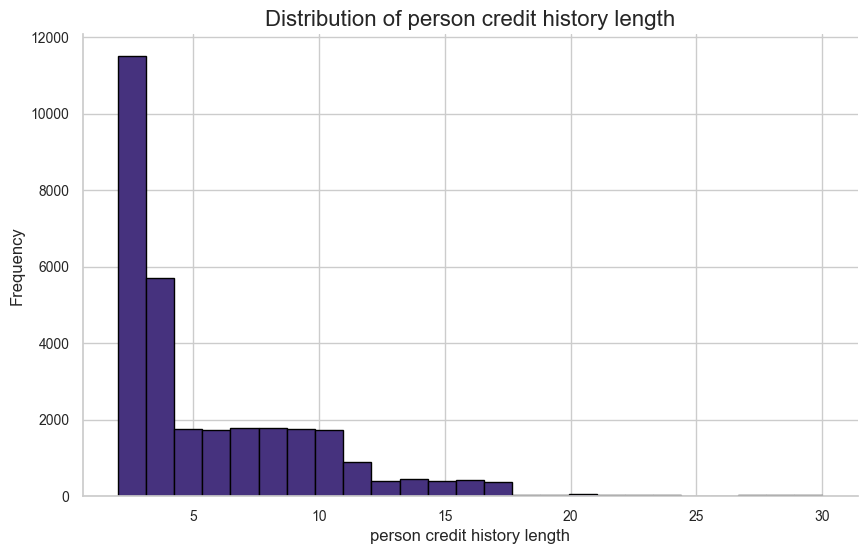

In [2116]:
hist_plot(df['cb_person_cred_hist_length'], 'person credit history length', bins=25)

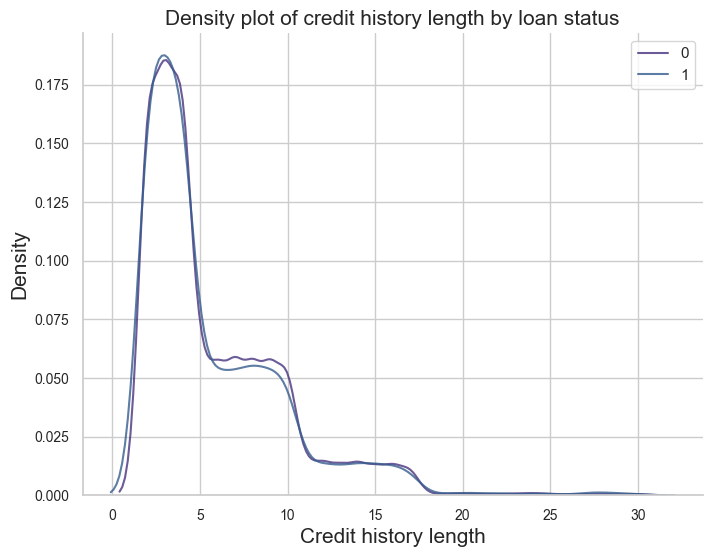

In [2117]:
plt.figure(figsize=(8,6))

for status in [0,1]:
    subset = df[df['loan_status'] == status]
    sns.kdeplot(subset['cb_person_cred_hist_length'].dropna(), label=status, fill=False, alpha=0.8)

plt.xlabel('Credit history length', size = 15)
plt.ylabel('Density', size = 15)
plt.title('Density plot of credit history length by loan status', size = 15)
plt.legend()
plt.show()

Особой разницы в распределении длины кредитной истории среди тех, кто вернул и кто не вернул кредит, нет, то есть не вернуть могут как и те, у кого практически нет опыта кредитования, так и те, у кого он есть. 

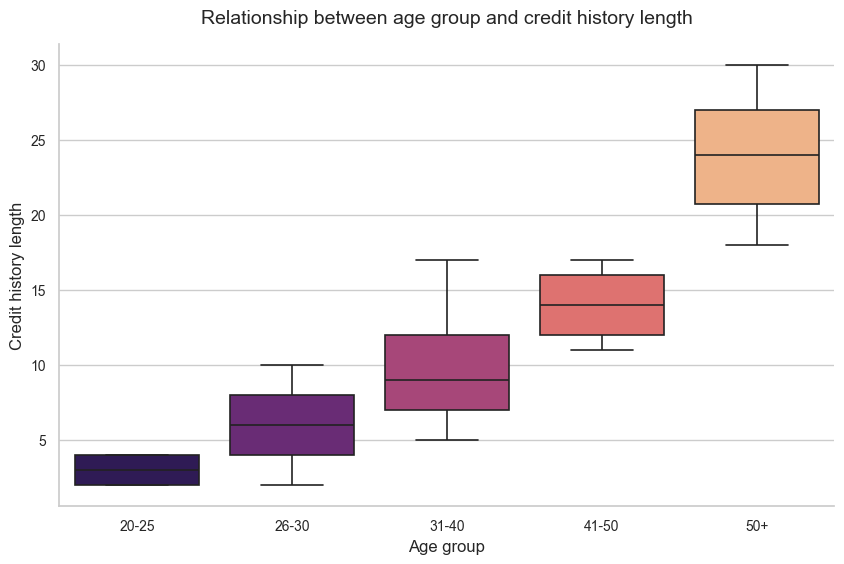

In [2118]:
plt.figure(figsize=(10, 6)) 
sns.boxplot(data=df, x='age_group', y='cb_person_cred_hist_length', hue='age_group',palette='magma', linewidth=1.2, fliersize=2)

plt.title('Relationship between age group and credit history length', fontsize=14, pad=15)
plt.xlabel('Age group', fontsize=12)
plt.ylabel('Credit history length', fontsize=12)
plt.show()

### Historical default

In [2119]:
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map({'N': 0, 'Y': 1})
df['cb_person_default_on_file'].value_counts()

cb_person_default_on_file
0    25479
1     5455
Name: count, dtype: int64

In [2120]:
print(df.groupby('cb_person_default_on_file')['loan_status'].mean() * 100)

cb_person_default_on_file
0   18.98
1   38.64
Name: loan_status, dtype: float64


Судя по данным, те, кто до это уже не возвращал кредит, более вероятно не вернут его снова. 

### Categorial features

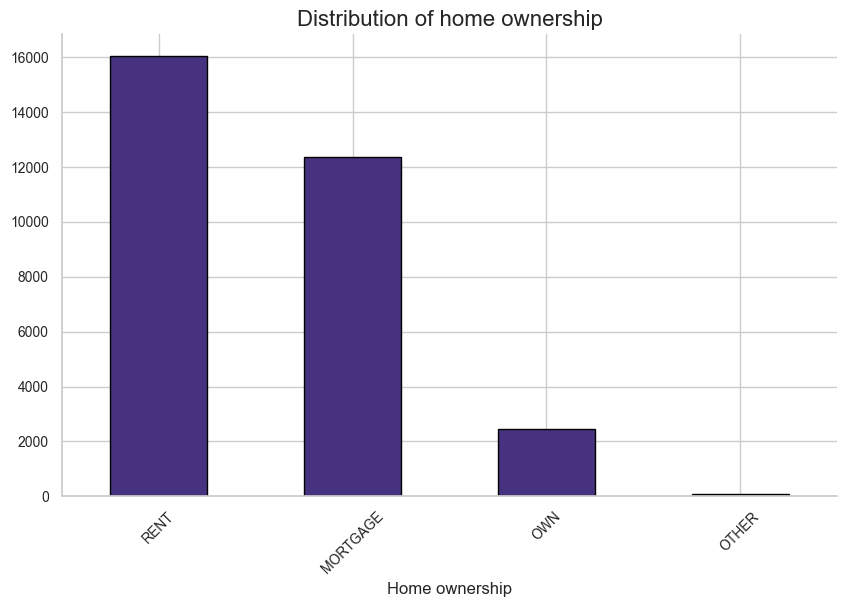

In [2121]:
df['person_home_ownership'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Distribution of home ownership')
plt.xlabel('Home ownership')
plt.xticks(rotation=45)
plt.show()

In [2122]:
print(df.groupby('person_home_ownership')['loan_status'].mean() * 100)

person_home_ownership
MORTGAGE   12.90
OTHER      32.32
OWN         7.80
RENT       31.98
Name: loan_status, dtype: float64


In [2123]:
df[df['person_home_ownership'] == 'OTHER'].shape[0]

99

В категории other очень мало значений, всего около 100, в дальнейшем это будет вредить построению модели, модель может переобучиться на этой маленькой выборе. Можем наблюдать, что риск в этой категории и в категории rent выше по сравнению с остальными. Возможно, имеет смысл записать все значения other в категорию rent (например, в категорию other могли быть занесены общежитие, дом родителей, служебное, все это можно приравнять к тому, что ты как бы "снимаешь" жилье).

In [2124]:
df['person_home_ownership'] = df['person_home_ownership'].replace('OTHER', 'RENT')

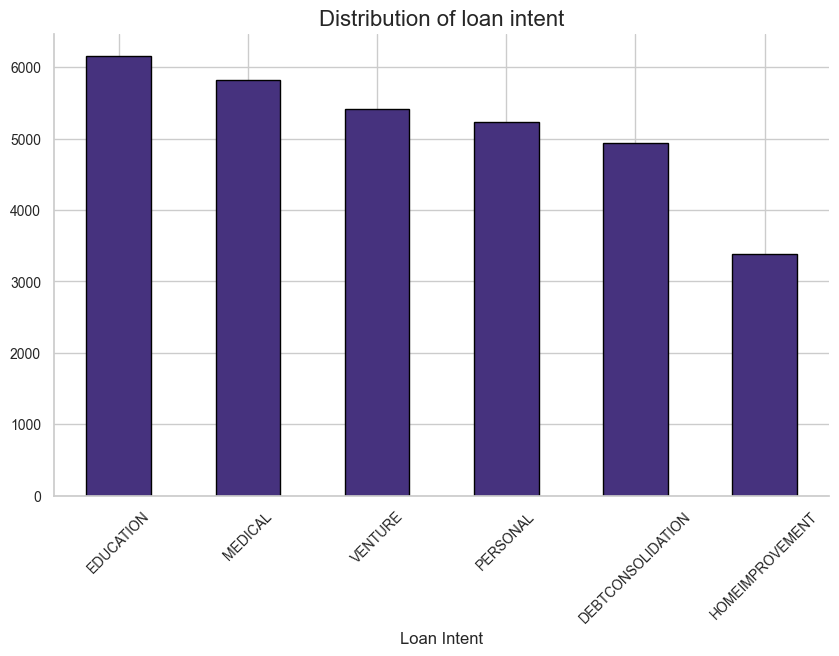

In [2125]:
df['loan_intent'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Distribution of loan intent')
plt.xlabel('Loan Intent')
plt.xticks(rotation=45)
plt.show()

In [2126]:
print(df.groupby('loan_intent')['loan_status'].mean() * 100)

loan_intent
DEBTCONSOLIDATION   29.17
EDUCATION           17.65
HOMEIMPROVEMENT     27.26
MEDICAL             27.22
PERSONAL            20.62
VENTURE             15.42
Name: loan_status, dtype: float64


Видим, что риск дефолта варьируется в зависимости от цели кредита, эта переменная может быть важна.

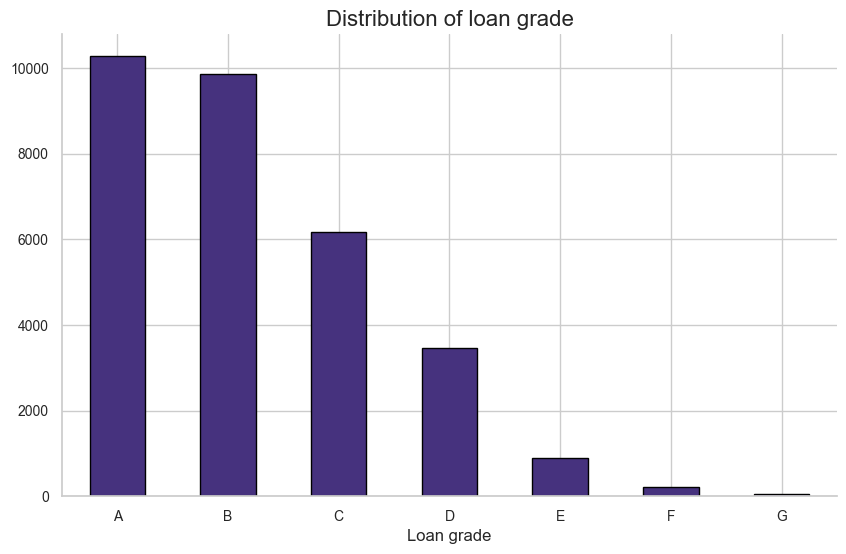

In [2127]:
df['loan_grade'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Distribution of loan grade')
plt.xlabel('Loan grade')
plt.xticks(rotation=0)
plt.show()

In [2128]:
print(df.groupby('loan_grade')['loan_status'].mean() * 100)

loan_grade
A   10.34
B   16.95
C   21.52
D   60.08
E   65.70
F   71.95
G   98.33
Name: loan_status, dtype: float64


### Correlation analysis

In [2129]:
numeric_df = df.select_dtypes(include=[np.number])
numeric_df

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,log_person_income,emp_is_missing
1,21,9600,5.00,6.91,11.14,0,0.10,0,2,9.17,0
2,25,9600,1.00,8.61,12.87,1,0.57,0,3,9.17,0
3,23,65500,4.00,10.46,15.23,1,0.53,0,2,11.09,0
4,24,54400,8.00,10.46,14.27,1,0.55,1,4,10.90,0
5,21,9900,2.00,7.82,7.14,1,0.25,0,2,9.20,0
...,...,...,...,...,...,...,...,...,...,...,...
32575,52,64500,0.00,8.52,11.26,0,0.08,0,20,11.07,0
32576,57,53000,1.00,8.67,13.16,0,0.11,0,30,10.88,0
32577,54,120000,4.00,9.78,7.49,0,0.15,0,19,11.70,0
32578,65,76000,3.00,10.46,10.99,1,0.46,0,28,11.24,0


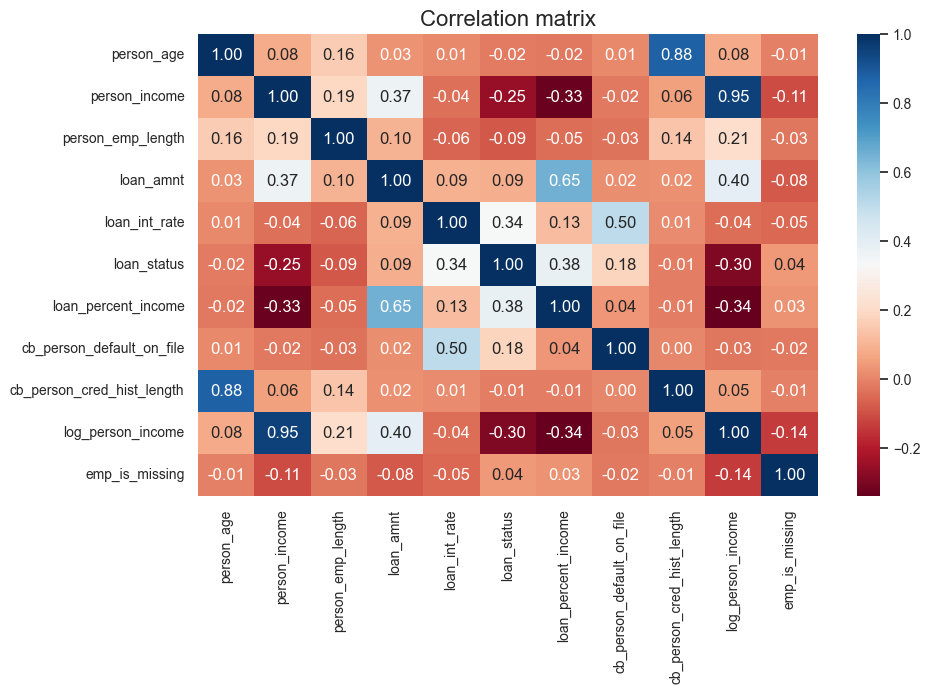

In [2130]:
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt='.2f')
plt.title('Correlation matrix')
plt.show()

In [2131]:
grades = [['A', 'B', 'C', 'D', 'E', 'F', 'G']]
ord_enc = OrdinalEncoder(categories=grades)
df[['loan_grade_enc']] = ord_enc.fit_transform(df[['loan_grade']])
df


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,log_person_income,age_group,emp_is_missing,loan_grade_enc
1,21,9600,OWN,5.00,EDUCATION,B,6.91,11.14,0,0.10,0,2,9.17,20-25,0,1.00
2,25,9600,MORTGAGE,1.00,MEDICAL,C,8.61,12.87,1,0.57,0,3,9.17,20-25,0,2.00
3,23,65500,RENT,4.00,MEDICAL,C,10.46,15.23,1,0.53,0,2,11.09,20-25,0,2.00
4,24,54400,RENT,8.00,MEDICAL,C,10.46,14.27,1,0.55,1,4,10.90,20-25,0,2.00
5,21,9900,OWN,2.00,VENTURE,A,7.82,7.14,1,0.25,0,2,9.20,20-25,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32575,52,64500,RENT,0.00,EDUCATION,B,8.52,11.26,0,0.08,0,20,11.07,50+,0,1.00
32576,57,53000,MORTGAGE,1.00,PERSONAL,C,8.67,13.16,0,0.11,0,30,10.88,50+,0,2.00
32577,54,120000,MORTGAGE,4.00,PERSONAL,A,9.78,7.49,0,0.15,0,19,11.70,50+,0,0.00
32578,65,76000,RENT,3.00,HOMEIMPROVEMENT,B,10.46,10.99,1,0.46,0,28,11.24,50+,0,1.00


In [2132]:
ohe_col = ['person_home_ownership', 'loan_intent', 'age_group']
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded = ohe.fit_transform(df[ohe_col])
encoded

array([[1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [2133]:
ohe.get_feature_names_out(ohe_col)

array(['person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL',
       'loan_intent_VENTURE', 'age_group_26-30', 'age_group_31-40',
       'age_group_41-50', 'age_group_50+'], dtype=object)

In [2134]:
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(ohe_col))
encoded_df

,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,age_group_26-30,age_group_31-40,age_group_41-50,age_group_50+
0,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
30929,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
30930,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
30931,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
30932,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [2135]:
df.reset_index(drop=True, inplace=True)
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,log_person_income,age_group,emp_is_missing,loan_grade_enc
0,21,9600,OWN,5.00,EDUCATION,B,6.91,11.14,0,0.10,0,2,9.17,20-25,0,1.00
1,25,9600,MORTGAGE,1.00,MEDICAL,C,8.61,12.87,1,0.57,0,3,9.17,20-25,0,2.00
2,23,65500,RENT,4.00,MEDICAL,C,10.46,15.23,1,0.53,0,2,11.09,20-25,0,2.00
3,24,54400,RENT,8.00,MEDICAL,C,10.46,14.27,1,0.55,1,4,10.90,20-25,0,2.00
4,21,9900,OWN,2.00,VENTURE,A,7.82,7.14,1,0.25,0,2,9.20,20-25,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30929,52,64500,RENT,0.00,EDUCATION,B,8.52,11.26,0,0.08,0,20,11.07,50+,0,1.00
30930,57,53000,MORTGAGE,1.00,PERSONAL,C,8.67,13.16,0,0.11,0,30,10.88,50+,0,2.00
30931,54,120000,MORTGAGE,4.00,PERSONAL,A,9.78,7.49,0,0.15,0,19,11.70,50+,0,0.00
30932,65,76000,RENT,3.00,HOMEIMPROVEMENT,B,10.46,10.99,1,0.46,0,28,11.24,50+,0,1.00


In [2136]:
df = pd.concat([df, encoded_df], axis = 1)
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,...,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,age_group_26-30,age_group_31-40,age_group_41-50,age_group_50+
0,21,9600,OWN,5.00,EDUCATION,B,6.91,11.14,0,0.10,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,25,9600,MORTGAGE,1.00,MEDICAL,C,8.61,12.87,1,0.57,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,23,65500,RENT,4.00,MEDICAL,C,10.46,15.23,1,0.53,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
3,24,54400,RENT,8.00,MEDICAL,C,10.46,14.27,1,0.55,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,21,9900,OWN,2.00,VENTURE,A,7.82,7.14,1,0.25,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30929,52,64500,RENT,0.00,EDUCATION,B,8.52,11.26,0,0.08,...,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
30930,57,53000,MORTGAGE,1.00,PERSONAL,C,8.67,13.16,0,0.11,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
30931,54,120000,MORTGAGE,4.00,PERSONAL,A,9.78,7.49,0,0.15,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
30932,65,76000,RENT,3.00,HOMEIMPROVEMENT,B,10.46,10.99,1,0.46,...,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [2137]:
df_model = df.drop(columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'person_age', 'age_group', 'person_income'])

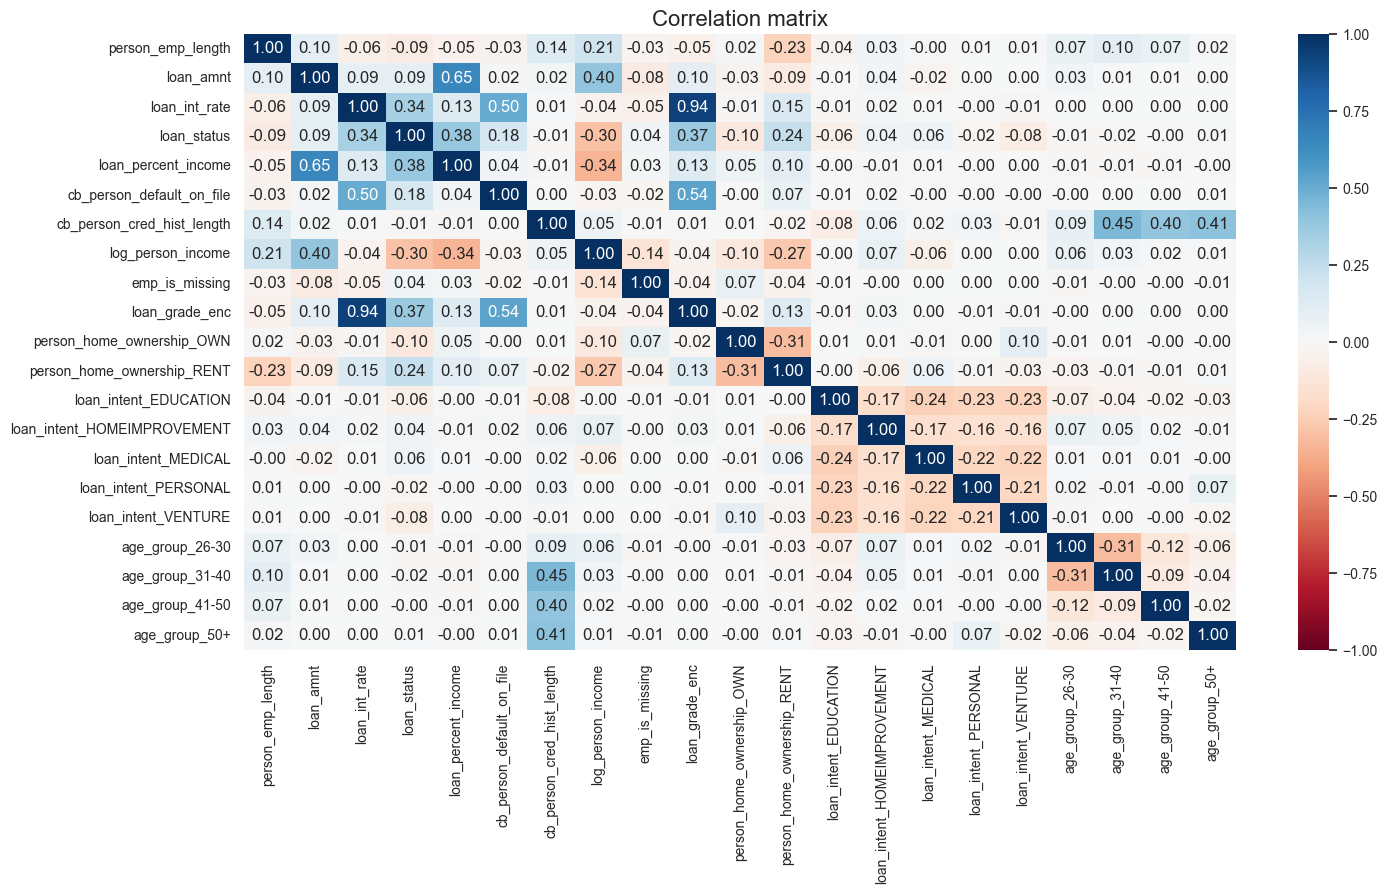

In [2138]:
plt.figure(figsize=(16,8))
sns.heatmap(df_model.corr(), annot=True, cmap='RdBu', fmt='.2f', vmin=-1, vmax=1,center=0)
plt.title('Correlation matrix')
plt.show()

Есть сильно скоррелированные переменные: ставка и грейд кредита, размер кредита и процент кредита от дохода. Оставим грейд кредита (у него более сильная корреляция со статусом и кажется, что этот показатель вбирает в себя больше информации, чем просто ставка) и оставим процент кредита (тоже более сильная корреляция, и дает более содержательную информацию, важно то, насколько велик размер запрашиваемого кредита относительно твоего дохода, чем размер кредита сам по себе).

In [2139]:
df_model.drop(columns=['loan_int_rate', 'loan_amnt'], inplace=True)

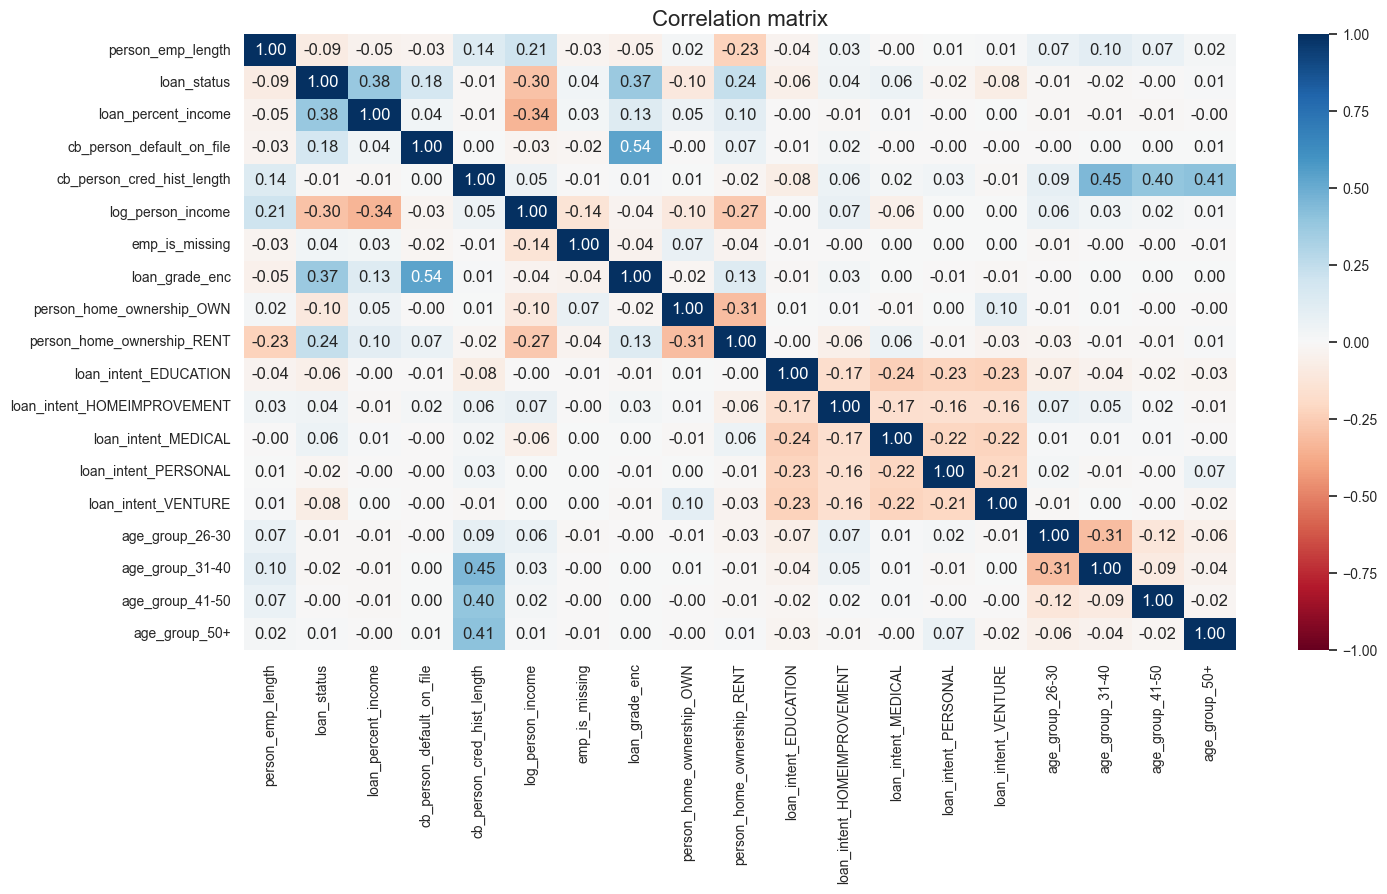

In [2140]:
plt.figure(figsize=(16,8))
sns.heatmap(df_model.corr(), annot=True, cmap='RdBu', fmt='.2f', vmin=-1, vmax=1,center=0)
plt.title('Correlation matrix')
plt.show()

In [2141]:
df_model.to_csv('credit_data_processed.csv', index=False)